# Ejercicio 2

In [11]:
# Para ejercicio 2:
# Agarrar el archivo txt "Mecanica_del_juego.txt" separar cada determinada cantidad de caracteres. Ej: 200. Y en base a eso
# ir vectorizando

In [12]:
# --------- Leer el texto desde el archivo ---------
with open("Mecanica_del_juego.txt", "r", encoding="utf-8") as file:
    texto = file.read()


In [13]:
import re
# Limpieza del texto (antes de fragmentar)
def limpiar_texto(texto):
    texto = texto.strip()
    texto = re.sub(r'\s+', ' ', texto)
    return texto

texto_limpio = limpiar_texto(texto)

In [14]:
# Función para dividir el texto en fragmentos de 200 caracteres
def fragmentar_texto(texto, tamaño_fragmento=200):
    fragmentos = [texto[i:i + tamaño_fragmento] for i in range(0, len(texto), tamaño_fragmento)]
    return fragmentos

# Dividimos el texto
fragmentos = fragmentar_texto(texto)


In [15]:
# Vectorización de los fragmentos
from sentence_transformers import SentenceTransformer
from prettytable import PrettyTable

# Cargamos el modelo preentrenado multilingüe
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Codificamos los fragmentos
embeddings = modelo.encode(fragmentos, convert_to_tensor=True)

d:\Documentos del Administrador\Desktop\Facultad\Cuartas Materias\NLP\TP 1 Parte 2\NLP_Parte2\entorno\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from sentence_transformers import util
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
import Levenshtein as lev
import numpy as np


frases_busqueda = [
    "¿Cuáles son las reglas básicas del juego de mesa?",
    "Cómo se juega a este juego de mesa",
    "Objetivo principal del juego",
    "Tipos de cartas en el juego",
    "Estrategias ganadoras en juegos de mesa",
    "Número de jugadores recomendado para este juego",
    "¿Es este juego cooperativo o competitivo?",
    "Historia del juego de mesa",
    "¿Qué hace especial este juego?",
    "¿Cómo se distribuyen las cartas en este juego?"
]

# Codificar los fragmentos y las frases de búsqueda
embeddings = modelo.encode(fragmentos, convert_to_tensor=True)
embeddings_busqueda = modelo.encode(frases_busqueda, convert_to_tensor=True)

# Función para calcular la similitud del coseno
def similitud_coseno(embedding1, embedding2):
    return util.cos_sim(embedding1, embedding2).item()

# Función para calcular la distancia de Jaccard
def distancia_jaccard(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - intersection / union  # Jaccard devuelve la distancia, no la similitud

# Función para calcular la distancia de Levenshtein
def distancia_levenshtein(str1, str2):
    return lev.distance(str1, str2)

# Función para calcular el índice de Dice
def indice_dice(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    return 2 * intersection / (len(set1) + len(set2))  # Dice devuelve la similitud

# Función para calcular la similitud de Jaro-Winkler
def similitud_jaro_winkler(str1, str2):
    return fuzz.ratio(str1, str2) / 100  # Jaro-Winkler es un porcentaje

# Crear una tabla para mostrar los resultados
tabla = PrettyTable()
tabla.field_names = ["Frase de Búsqueda", "Fragmento", "Similitud Coseno", "Distancia Jaccard", "Distancia Levenshtein", "Índice Dice", "Similitud Jaro-Winkler"]

# Comparar todas las frases de búsqueda con todos los fragmentos
for i, frase in enumerate(frases_busqueda):
    for j, fragmento in enumerate(fragmentos):
        similitud_cos = similitud_coseno(embeddings_busqueda[i], embeddings[j])
        jaccard = distancia_jaccard(frase, fragmento)
        levenshtein = distancia_levenshtein(frase, fragmento)
        dice = indice_dice(frase, fragmento)
        jaro_winkler = similitud_jaro_winkler(frase, fragmento)

        # Añadir la fila a la tabla
        tabla.add_row([frase, fragmento, f"{similitud_cos:.4f}", f"{jaccard:.4f}", f"{levenshtein:.4f}", f"{dice:.4f}", f"{jaro_winkler:.4f}"])

# Mostrar la tabla con los resultados
print(tabla)


+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-------------------+-----------------------+-------------+------------------------+
|                 Frase de Búsqueda                 |                                                                                                Fragmento                                                                                                 | Similitud Coseno | Distancia Jaccard | Distancia Levenshtein | Índice Dice | Similitud Jaro-Winkler |
+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-------

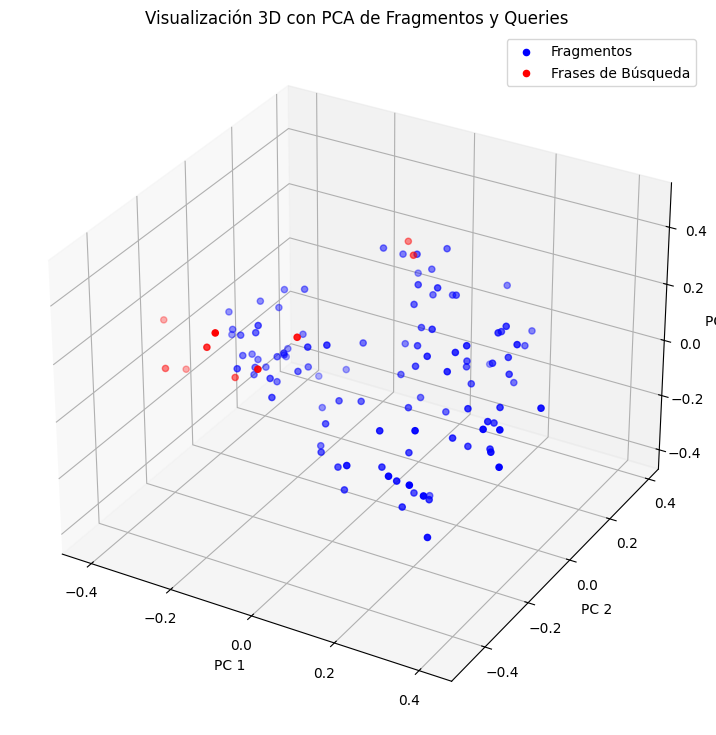

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Combina los embeddings de fragmentos y frases de búsqueda
todos_embeddings = embeddings.cpu().numpy().tolist() + embeddings_busqueda.cpu().numpy().tolist()


# Aplica PCA para reducir a 3 dimensiones
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(todos_embeddings)

# Separa fragmentos y frases de búsqueda
num_fragmentos = len(fragmentos)
emb_frag = embeddings_3d[:num_fragmentos]
emb_query = embeddings_3d[num_fragmentos:]

# Visualización 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Fragmentos en azul
ax.scatter(emb_frag[:, 0], emb_frag[:, 1], emb_frag[:, 2], c='blue', label='Fragmentos')
# Frases de búsqueda en rojo
ax.scatter(emb_query[:, 0], emb_query[:, 1], emb_query[:, 2], c='red', label='Frases de Búsqueda')



ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Visualización 3D con PCA de Fragmentos y Queries')
ax.legend()
plt.show()


# Ejercicio 3

In [19]:
import spacy

# Carga el modelo en español con soporte para POS y NER
nlp = spacy.load('es_core_news_lg')

# Lista de fragmentos ya obtenida (fragmentos limpiados y fragmentados)
# Por ejemplo:
# fragmentos = ["El jugador corre hacia el balón.", "La FIFA organiza el torneo."]

for i, fragmento in enumerate(fragmentos):
    doc = nlp(fragmento)
    
    print(f"\n--- Fragmento {i+1} ---")
    print(f"Texto: {fragmento}\n")

    # 1. Extraer frases nominales (noun_chunks = frases con núcleo sustantivo)
    print("Frases nominales (POS):")
    for chunk in doc.noun_chunks:
        print(f" - {chunk.text}")

    # 2. Extraer entidades nombradas (NER)
    print("\nEntidades nombradas (NER):")
    for ent in doc.ents:
        print(f" - {ent.text} ({ent.label_})")



--- Fragmento 1 ---
Texto: Conviértete en un explorador que compite con otros por ver quién es el observador de la naturaleza más hábil en un viaje para el que no se necesita más que el deseo por descubrir los misterios de la n

Frases nominales (POS):
 - Conviértete
 - un explorador
 - que
 - otros
 - quién
 - la naturaleza
 - un viaje
 - el que
 - más que el deseo
 - los misterios
 - la n

Entidades nombradas (NER):

--- Fragmento 2 ---
Texto: aturaleza y una mirada llena de curiosidad por cada pequeño detalle que nos encontremos en el camino.
Así se nos presenta Pradera, diseñado por Klemens Kalicki, responsable de Dream Home. El juego fue

Frases nominales (POS):
 - aturaleza
 - una mirada
 - curiosidad
 - cada pequeño detalle
 - que
 - el camino
 - nos
 - Pradera, diseñado por Klemens Kalicki, responsable de Dream Home
 - El juego

Entidades nombradas (NER):
 - aturaleza (LOC)
 - Pradera (LOC)
 - Klemens Kalicki (PER)
 - Dream Home (MISC)
 - El juego (MISC)

--- Fragmento 3 ---
T

In [20]:
import spacy

# Carga el modelo grande de spaCy en español
nlp = spacy.load('es_core_news_lg')

# Recorre todos los fragmentos procesando cada uno
for i, fragmento in enumerate(fragmentos):
    doc = nlp(fragmento)
    
    print(f"\n--- Fragmento {i+1} ---")
    print(f"Texto: {fragmento}\n")

    # 1. Frases nominales (grupos con sustantivos)
    print("Frases nominales (POS):")
    for chunk in doc.noun_chunks:
        print(f" - {chunk.text}")
    
    # 2. Entidades nombradas con explicación
    print("\nEntidades nombradas (NER):")
    for ent in doc.ents:
        print(f" - Entidad: {ent.text}, Etiqueta: {ent.label_}, Explicación: {spacy.explain(ent.label_)}")



--- Fragmento 1 ---
Texto: Conviértete en un explorador que compite con otros por ver quién es el observador de la naturaleza más hábil en un viaje para el que no se necesita más que el deseo por descubrir los misterios de la n

Frases nominales (POS):
 - Conviértete
 - un explorador
 - que
 - otros
 - quién
 - la naturaleza
 - un viaje
 - el que
 - más que el deseo
 - los misterios
 - la n

Entidades nombradas (NER):

--- Fragmento 2 ---
Texto: aturaleza y una mirada llena de curiosidad por cada pequeño detalle que nos encontremos en el camino.
Así se nos presenta Pradera, diseñado por Klemens Kalicki, responsable de Dream Home. El juego fue

Frases nominales (POS):
 - aturaleza
 - una mirada
 - curiosidad
 - cada pequeño detalle
 - que
 - el camino
 - nos
 - Pradera, diseñado por Klemens Kalicki, responsable de Dream Home
 - El juego

Entidades nombradas (NER):
 - Entidad: aturaleza, Etiqueta: LOC, Explicación: Non-GPE locations, mountain ranges, bodies of water
 - Entidad: Pradera,

In [ ]:
# Dudas: 
# Las justificaciones que deben estar en el informe, a que se refieren? es decir, que hay que justificar? 
# Debo cargar todo el repositorio o solo los archivos que voy a usar?
# Antes de utilizar un modelo de embedding, debo hacerle un tratamiento previo al texto? Ej: eliminar stopwords, lematizar, etc?